# Create context-specific models using Mouse G6PD variants omics data
## Setup
### Import packages

In [1]:
import re
from collections import defaultdict

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664191

Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                              3.4.2
notebook                              7.4.2
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scikit-learn                          1.6.1
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Define organism, model, and dataset

In [3]:
organism = "Mouse"
model_id = "RBC_GEM"
dataset_name = "G6PDvariants"

## Set variables for columns keys and sample identification

In [4]:
sample_key = "SAMPLE ID"
donor_key = "MOUSE ID"
time_key = "TIME"

timepoints = ["Pre", "Post", "TD"]
phenotypes = ["HumCan", "A", "MED"]

# For sample IDs
donor_re = re.compile(rf"(?P<donor>({'|'.join(phenotypes)})\d+)")
time_re = re.compile(rf"(?P<time>{'|'.join(timepoints)})")
phenotype_re = re.compile(rf"(?P<phenotype>({'|'.join(phenotypes)}))")

operations = "|".join([x.capitalize() for x in ["mean", "median"]]) 

operation_re = re.compile(
    r"(?P<op>" 
    + operations 
    + r")\_(?P<group>\w+)"
)
sample_id_re = re.compile(
    r"(?!" + operations + r")" 
    + donor_re.pattern
    + r"\_"
    + time_re.pattern
)

## Set computation options

In [5]:
run_computations = False
verbose = True
objective_reactions = ["NaKt"]

## Set figure options

In [6]:
save_figures = True
transparent = False
imagetype = "svg"

## Load RBC-GEM model

In [7]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id

results_dirpath = get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name

fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True)
sample_pcmodels_dirpath.mkdir(exist_ok=True)

# Identify hemoglobin proteins
if organism == "Mouse":
    hemoglobin_proteins = {
        k.replace("-", "_"): v
        for k, v in {
            "Hba": "P01942",  # Hemoglobin subunit alpha
            "Hba-a1": "P01942",
            "Hbb-b1": "P02088",  # Hemoglobin subunit beta-1
            "Hbb-b2": "P02089",  # Hemoglobin subunit beta-2
            "Hbb-bh0": "P04443",  # Hemoglobin subunit beta-H0
            "Hbb-bh1": "P04444",  # Hemoglobin subunit beta-H1
            "Hbz": "P06467",  # Hemoglobin subunit zeta
            "Hba-x": "P06467",
            "Hbz1": "P06467",
            "Hbb-y": "P02104",  # Hemoglobin subunit epsilon-Y2
        }.items()
    }
else:
    hemoglobin_proteins = {
        "HBA": "P69905",  # Hemoglobin subunit alpha
        "HBB": "P68871",  # Hemoglobin subunit beta
        "HBD": "P02042",  # Hemoglobin subunit delta
        "HBE1": "P02100",  # Hemoglobin subunit beta
        "HBG1": "P69891",  # Hemoglobin subunit gamma-1
        "HBG2": "P69892",  # Hemoglobin subunit gamma-2
        "HBM": "Q6B0K9",  # Hemoglobin subunit mu
        "HBQ1": "P09105",  # Hemoglobin subunit theta-1
        "HBZ": "P02008",  # Hemoglobin subunit zeta
    }

# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,27ae75e34d0
Number of metabolites,10396
Number of reactions,18932
Number of genes,823
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load copy numbers and protein data

In [8]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinCopyNumbers.tsv", sep="\t", index_col=sample_key
)

# Load MCH for transforming data
df_MCH = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_MCH.tsv", sep="\t", index_col=sample_key
)
# Load intensity data as weighting matrix
df_weighting_mat = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinIntensities.tsv", sep="\t", index_col=sample_key
)

# Load protein data
df_protein_data = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)

all_ids = list(df_copy_numbers.index.unique())
operation_ids = [x for x in all_ids if operation_re.match(x)]
sample_ids = [x for x in all_ids if sample_id_re.match(x)]

print(f"Number of measured samples: {len(sample_ids)}")
print(f"Number of operation samples: {len(operation_ids)}")
print(f"Number of models to generate: {len(all_ids)}")
print(f"\nNumber of timepoints across samples: {len(timepoints)}")

Number of measured samples: 107
Number of operation samples: 18
Number of models to generate: 125

Number of timepoints across samples: 3


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [9]:
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol
df_mg_prot_per_gDW = (
    df_copy_numbers[df_protein_data.index].mul(1 / df_MCH.squeeze(), axis=0)  # cell / pgDW
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_copy_numbers.index]
df_mg_prot_per_gDW

,A2AAY5,A2ADY9,A2AGT5,A2AN08,A2AQ07,A2AVZ9,A6X935,B2RPV6,B2RQC6,C0HKE1,...,Q9Z1Z0,Q9Z2K1,Q9Z2L7,Q9Z2M7,Q9Z2U0,Q9Z2U1,Q9Z2W0,Q9Z2X1,Q9Z2Y8,V9GXG1
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
A10_Post,0.000129,0.065325,0.0,0.122437,0.015288,0.00000,0.039182,0.000000,0.000000,0.062078,...,0.000000,0.009719,0.036777,0.140279,0.336252,0.405873,0.116476,0.00000,0.026443,0.000000
A10_Pre,0.000000,0.019904,0.0,0.141791,0.038107,0.00000,0.108696,0.016981,0.000000,0.033990,...,0.002767,0.000000,0.023859,0.143381,0.315972,0.444422,0.168222,0.00000,0.023482,0.000000
A10_TD,0.000000,0.124343,0.0,0.355542,0.098399,0.00573,0.042256,0.016195,0.051999,0.002731,...,0.010588,0.007346,0.057372,0.149362,0.295616,0.454109,0.114021,0.00525,0.024966,0.020311
A11_Post,0.000000,0.045727,0.0,0.198813,0.052438,0.00000,0.248604,0.017542,0.000000,0.080927,...,0.000000,0.000000,0.044378,0.119848,0.328272,0.449706,0.073465,0.00000,0.024687,0.000000
A11_Pre,0.000000,0.021274,0.0,0.119736,0.000000,0.00000,0.000000,0.000000,0.000000,0.006061,...,0.000000,0.000000,0.021043,0.158976,0.211475,0.406678,0.182210,0.00000,0.016330,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Pre_HumCan,0.000000,0.042820,0.0,0.186949,0.061364,0.00000,0.154674,0.014304,0.000000,0.098526,...,0.000000,0.000000,0.022715,0.142094,0.248232,0.440393,0.138015,0.00000,0.017012,0.000000
Median_Pre_MED,0.000114,0.046607,0.0,0.162089,0.059232,0.00000,0.348458,0.015668,0.000000,0.061583,...,0.000000,0.000000,0.024128,0.122169,0.281648,0.434512,0.137149,0.00000,0.019474,0.000000
Median_TD_A,0.000000,0.095657,0.0,0.324819,0.122700,0.00000,0.112460,0.054893,0.054941,0.027957,...,0.002642,0.000000,0.040128,0.173731,0.255944,0.394790,0.134101,0.00000,0.022271,0.012562


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [10]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [11]:
# Split into hemoglobin and low abundance proteomes
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[
    :, df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[
    :, ~df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())
]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids]
    .sum(axis=1)
    .mean()
    .item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               1000.0000     100.0%
    Hemoglobin total                627.5881      62.8%
 Low abundance total                372.4119      37.2%
    Remaining/Excess                  0.0000       0.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
A10_Post             1000.0
A10_Pre              1000.0
A10_TD               1000.0
A11_Post             1000.0
A11_Pre              1000.0
                      ...  
Median_Pre_HumCan    1000.0
Median_Pre_MED       1000.0
Median_TD_A          1000.0
Median_TD_HumCan     1000.0
Median_TD_MED        1000.0
Length: 125, dtype: float64

### Convert mg / gDW to nmol / gDW

In [12]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,A12_Pre,A12_TD,A1_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
P01942,27281.943107,27597.198651,30220.375425,28549.858810,27578.780174,28039.216086,28432.121483,26676.853433,27694.946744,28294.081672,...,27263.259635,28371.366236,29840.437123,29232.166845,27758.076118,28727.539194,28742.154954,28563.191913,27821.330477,27222.249557
P02088,33928.877308,33635.077094,31127.784974,32724.102496,33545.442645,33154.672587,32783.381999,34374.173390,33408.195122,32954.614249,...,33923.078011,32890.301809,31490.347314,32044.844423,33447.997879,32543.943942,32528.164227,32691.838247,33421.568139,33969.650263
P02089,47.610448,36.948910,49.639535,46.439585,144.159638,100.479173,100.379249,176.506534,174.599482,54.749946,...,67.955984,48.619000,51.297357,74.957829,71.237111,51.709134,54.778694,66.147076,35.867977,63.843727
P02104,6.996961,6.147224,9.065558,7.502528,6.839547,5.190216,3.176937,1.696664,0.614743,5.254978,...,5.452480,7.007395,7.015979,5.713521,6.165484,6.930567,6.527103,5.905510,6.089699,2.195510
P04443,9.131043,14.084755,7.754838,7.150897,13.119695,10.940475,10.228797,16.040628,15.485043,13.950748,...,13.743954,9.186331,7.457779,9.768554,13.582769,13.191103,12.412549,8.541972,15.247145,13.669777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,2.106064,2.510406,2.124409,2.150825,2.401325,2.415088,2.119296,2.529920,2.094621,1.489780,...,2.124319,2.015789,2.184640,2.180583,2.310189,2.301725,2.195816,1.964801,1.737682,2.373220
Q9Z2W0,0.305755,0.480715,0.269847,0.177751,0.544287,0.402257,0.407161,0.642554,0.274465,0.392817,...,0.394878,0.297909,0.356898,0.321652,0.376936,0.364919,0.350625,0.337630,0.368882,0.443358
Q9Z2X1,0.000000,0.000000,0.014185,0.000000,0.000000,0.000000,0.022979,0.000000,0.000000,0.000000,...,0.030143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q9Z2Y8,0.120598,0.116584,0.102657,0.103778,0.084749,0.095287,0.139247,0.092897,0.090707,0.071412,...,0.073695,0.096739,0.099391,0.098149,0.085034,0.078150,0.086498,0.097419,0.101935,0.080881


## Create DataFrame for protein dilution reactions

In [13]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q67BJ4,A4galt,PROTDL_protein_A4galt_pc
Q8BGQ7,Aars1,PROTDL_protein_Aars1_pc
Q9CQF6,Aasdhppt,PROTDL_protein_Aasdhppt_pc
P41233,Abca1,PROTDL_protein_Abca1_pc
Q91V24,Abca7,PROTDL_protein_Abca7_pc
...,...,...
Q04736,Yes1,PROTDL_protein_Yes1_pc
Q5Y5T1,Zdhhc20,PROTDL_protein_Zdhhc20_pc
P59267,Zdhhc2,PROTDL_protein_Zdhhc2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [14]:
df_samples = df_nmol_prot_per_gDW.copy()
df_samples

SAMPLE ID,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,A12_Pre,A12_TD,A1_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
P01942,27281.943107,27597.198651,30220.375425,28549.858810,27578.780174,28039.216086,28432.121483,26676.853433,27694.946744,28294.081672,...,27263.259635,28371.366236,29840.437123,29232.166845,27758.076118,28727.539194,28742.154954,28563.191913,27821.330477,27222.249557
P02088,33928.877308,33635.077094,31127.784974,32724.102496,33545.442645,33154.672587,32783.381999,34374.173390,33408.195122,32954.614249,...,33923.078011,32890.301809,31490.347314,32044.844423,33447.997879,32543.943942,32528.164227,32691.838247,33421.568139,33969.650263
P02089,47.610448,36.948910,49.639535,46.439585,144.159638,100.479173,100.379249,176.506534,174.599482,54.749946,...,67.955984,48.619000,51.297357,74.957829,71.237111,51.709134,54.778694,66.147076,35.867977,63.843727
P02104,6.996961,6.147224,9.065558,7.502528,6.839547,5.190216,3.176937,1.696664,0.614743,5.254978,...,5.452480,7.007395,7.015979,5.713521,6.165484,6.930567,6.527103,5.905510,6.089699,2.195510
P04443,9.131043,14.084755,7.754838,7.150897,13.119695,10.940475,10.228797,16.040628,15.485043,13.950748,...,13.743954,9.186331,7.457779,9.768554,13.582769,13.191103,12.412549,8.541972,15.247145,13.669777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,2.106064,2.510406,2.124409,2.150825,2.401325,2.415088,2.119296,2.529920,2.094621,1.489780,...,2.124319,2.015789,2.184640,2.180583,2.310189,2.301725,2.195816,1.964801,1.737682,2.373220
Q9Z2W0,0.305755,0.480715,0.269847,0.177751,0.544287,0.402257,0.407161,0.642554,0.274465,0.392817,...,0.394878,0.297909,0.356898,0.321652,0.376936,0.364919,0.350625,0.337630,0.368882,0.443358
Q9Z2X1,0.000000,0.000000,0.014185,0.000000,0.000000,0.000000,0.022979,0.000000,0.000000,0.000000,...,0.030143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q9Z2Y8,0.120598,0.116584,0.102657,0.103778,0.084749,0.095287,0.139247,0.092897,0.090707,0.071412,...,0.073695,0.096739,0.099391,0.098149,0.085034,0.078150,0.086498,0.097419,0.101935,0.080881


### Map samples to model

In [15]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model[~df_model.isna().all(axis=1)]

Model proteins mapped to measurements: 363
Model proteins without measurements: 460


,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,A12_Pre,A12_TD,A1_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_Aars1_pc,0.164594,0.140646,0.338898,0.188735,0.127827,0.266558,0.147593,0.157279,0.235051,0.117802,...,0.153874,0.166842,0.149564,0.131755,0.148260,0.120930,0.111309,0.232741,0.189097,0.141261
PROTDL_protein_Abcb4_pc,0.021240,0.020697,0.043262,0.015841,0.049605,0.036366,0.024446,0.023289,0.043610,0.020489,...,0.018104,0.021936,0.021551,0.022035,0.026602,0.038213,0.038014,0.039344,0.023764,0.015534
PROTDL_protein_Abcb6_pc,0.025318,0.002897,0.011231,0.010429,0.019812,0.012001,0.000000,0.009121,0.015646,0.007273,...,0.003063,0.016370,0.006007,0.007312,0.008447,0.004477,0.007604,0.011725,0.005747,0.000000
PROTDL_protein_Abcc1_pc,0.007509,0.006337,0.008412,0.006028,0.005205,0.005081,0.006521,0.000000,0.006239,0.004485,...,0.001611,0.006138,0.005539,0.006638,0.003900,0.003585,0.003977,0.005308,0.000000,0.000000
PROTDL_protein_Abce1_pc,0.000000,0.000000,0.064781,0.000000,0.000000,0.000000,0.000000,0.000000,0.065474,0.000000,...,0.039122,0.000000,0.000000,0.000000,0.000000,0.023798,0.000000,0.065280,0.072156,0.048339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_Wars1_pc,0.018895,0.153560,0.239942,0.015348,0.136122,0.106539,0.000000,0.151362,0.208092,0.110792,...,0.200336,0.017886,0.122158,0.030137,0.160309,0.197658,0.199535,0.189937,0.151378,0.202796
PROTDL_protein_Wdr77_pc,0.000000,0.000000,0.024314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_Wnk1_pc,0.006349,0.006331,0.007644,0.008355,0.006108,0.008194,0.006462,0.000000,0.000000,0.000000,...,0.123113,0.008184,0.007351,0.002487,0.006303,0.001803,0.006471,0.006830,0.000932,0.000000


#### Summarize mapping

In [16]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW_normalized.columns
        if x in list(hemoglobin_proteins.values())
    ],
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW.columns
        if not x in list(hemoglobin_proteins.values())
    ],
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       25.051519
Mean low abundance mass remaining     24.948481
Name: Mean value across samples, dtype: float64


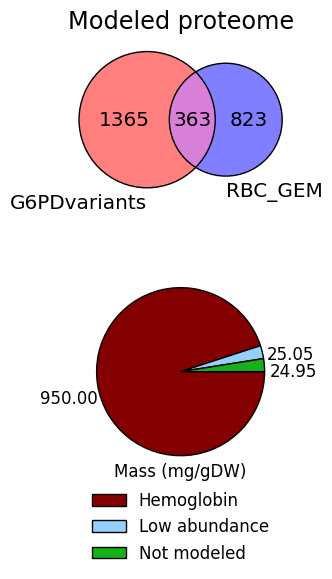

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [18]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(
    pcmodel, df_samples, df_weights=None, log_zero_replacement=1e-6, verbose=False
):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = (
            df_model_data_weights.loc[:, [data_series.name, data_weights.name]]
            .dropna(axis=0, how="all")
            .astype(float)
        )

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)
        
        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        df = df_qp_sol.copy()
        r2 = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
        
        df = df_qp_sol.apply(lambda x: [log_zero_replacement if np.isclose(y, 0, atol=1e-12) else y for y in x]).apply(np.log10)
        r2_log10_w_outliers = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")

        df = df_qp_sol[~df_qp_sol.apply(lambda x: np.isclose(x, 0).any(), axis=1)].apply(np.log10)
        r2_log10_wo_outliers = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
        r2_values = (r2, r2_log10_w_outliers, r2_log10_wo_outliers)
        qp_solutions_dict[sample_id] = (df_qp_sol, qp_sol.objective_value, r2_values)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print("Sample '{}'\tR^2: {:.4f}\tR^2 log10 w/outliers: {:.4f}\tR^2 log10 wo/outliers: {:.4f}\tObjective: {:.5f}".format(sample_id, *r2_values, qp_sol.objective_value))
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [19]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_weighting_mat.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,A12_Pre,A12_TD,A1_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
Entry,,,,,,,,,,,,,,,,,,,,,
A2AAY5,0.006625,2.116233,3.152298,2.403105,1.901082,0.000022,2.170059,1.963994,2.190963,2.233996,...,0.084784,2.407324,2.271157,2.252409,2.305675,2.223050,0.007854,3.053540,2.411583,2.046409
A2ADY9,0.000013,0.000041,0.000010,0.000020,0.000038,0.000011,0.000013,0.000020,0.000010,0.000018,...,0.000030,0.000014,0.000012,0.000014,0.000023,0.000021,0.000019,0.000013,0.000011,0.000013
A2AGT5,2.109680,2.116233,3.152298,2.403105,1.901082,2.655558,2.170059,1.963994,2.190963,2.233996,...,0.009934,2.407324,2.271157,2.252409,2.305675,2.223050,2.263601,3.053540,2.411583,2.046409
A2AN08,0.000007,0.000006,0.000003,0.000005,0.000007,0.000003,0.000004,0.000002,0.000003,0.000004,...,0.000014,0.000004,0.000004,0.000005,0.000005,0.000005,0.000006,0.000004,0.000005,0.000006
A2AQ07,0.000056,0.000022,0.000012,0.000017,1.901082,0.000008,0.000018,0.000024,0.000012,0.000013,...,0.000007,0.000015,0.000025,0.000015,0.000016,0.000015,0.000015,0.000010,0.000008,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,...,0.000007,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000003
Q9Z2W0,0.000007,0.000005,0.000010,0.000012,0.000004,0.000007,0.000006,0.000004,0.000009,0.000005,...,0.000018,0.000008,0.000007,0.000008,0.000006,0.000007,0.000007,0.000009,0.000007,0.000007
Q9Z2X1,2.109680,2.116233,0.000226,2.403105,1.901082,2.655558,0.000124,1.963994,2.190963,2.233996,...,0.000272,2.407324,2.271157,2.252409,2.305675,2.223050,2.263601,3.053540,2.411583,2.046409


### Fit data by solving QP

In [20]:
log_zero_replacement = 1e-9
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel,
        df_samples,
        df_weights=df_weights,
        log_zero_replacement=log_zero_replacement,
        verbose=True,
    )

    for sample_id, (
        df_qp_sol,
        objective_value,
        r2_values,
    ) in qp_solutions_dict.items():
        fitting_data["measured"][sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        fitting_data["best_fit"][sample_id] = df_qp_sol[
            "Best-Fitted Proteome"
        ].to_dict()
        fitting_data["r2_objective"][sample_id] = {
            "Objective": objective_value,
            "R^2" : r2_values[0],
            "R^2 log10 w/ outliers": r2_values[1],
            "R^2 log10 w/o outliers": r2_values[2],
        }
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index=True)
        fitting_data[key] = data
else:
    for key in fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index_col=0
        )
    qp_solutions_dict = {}
    for sample_id in df_samples.columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2_values = (
            fitting_data["r2_objective"].loc[:, sample_id].values
        )
        objective_value, r2_values = r2_values[0], r2_values[1:]
        qp_solutions_dict[sample_id] = (df_qp_sol, objective_value, r2_values)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

Number of QP solutions: 125


### Plot fitting 
#### For the mean and median samples of each time point and for each chosen phenotype

In [21]:
samples_to_plot = np.array([
    # Best for 1 or 3 columns 
    [
        x
        for x in operation_ids 
        
        if (timepoint in x and phenotype in x)
    ]
    for phenotype in phenotypes
    for timepoint in timepoints
    
]).T
samples_to_plot

array([['Mean_Pre_HumCan', 'Mean_Post_HumCan', 'Mean_TD_HumCan',
        'Mean_Pre_A', 'Mean_Post_A', 'Mean_TD_A', 'Mean_Pre_MED',
        'Mean_Post_MED', 'Mean_TD_MED'],
       ['Median_Pre_HumCan', 'Median_Post_HumCan', 'Median_TD_HumCan',
        'Median_Pre_A', 'Median_Post_A', 'Median_TD_A', 'Median_Pre_MED',
        'Median_Post_MED', 'Median_TD_MED']], dtype='<U18')

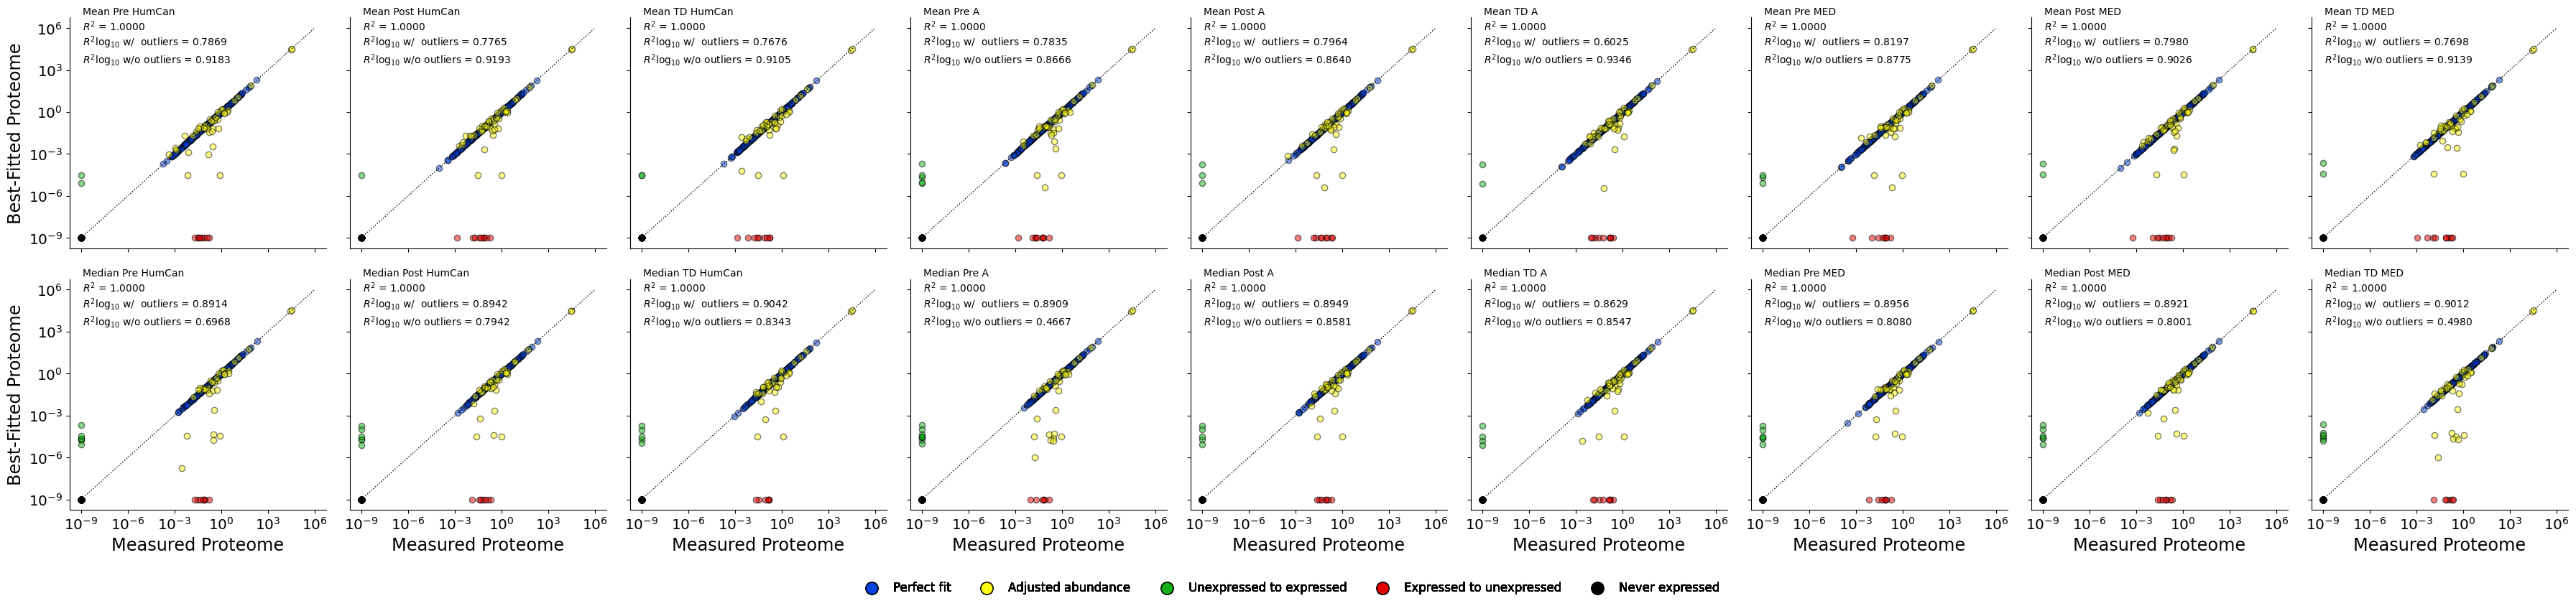

In [22]:
r2_text_loc = "upper left"
transform = False

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)
for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, objective_value, r2_values = qp_solutions_dict[sample_id]
    # Copy to prevent alterations to the original
    df_qp_sol = df_qp_sol.copy()
    xlabel, ylabel = df_qp_sol.columns

    ticks = 10 ** np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
    if transform:
        ticks = np.log10(ticks)
        df_qp_sol.iloc[:, 0] = (
            df_qp_sol.iloc[:, 0]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
            .apply(np.log10)
        )
        df_qp_sol.iloc[:, 1] = (
            df_qp_sol.iloc[:, 1]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
            .apply(np.log10)
        )
    perfect_fit_line = ax.plot(
        [ticks[0], ticks[-1]],
        [ticks[0], ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )

    zero_val = 0 if not transform else np.log10(log_zero_replacement)

    df_zeros = df_qp_sol[
        (df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)
    ]
    df_perfect = df_qp_sol[
        np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

    df_altered = df_qp_sol[
        ~np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], zero_val)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], zero_val)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    op, time, phenotype = str(sample_id.replace(f"{pcmodel.id}_", "")).split("_")
    sample_label = " ".join((op, time, phenotype))

    if not transform:
        ax.set_xscale("log")
        ax.set_yscale("log")

    fontdict = {"size": "xx-large"}
    if idx >= len(samples_to_plot.flatten()) - ncols:
        ax.set_xlabel(xlabel, fontdict=fontdict)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        ncols=len(labels),
        frameon=False,
        fontsize="large",
        markerscale=2,
        bbox_to_anchor=(0.5, -0.01),
    )
    if idx % ncols == 0:
        ax.set_ylabel(ylabel, fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    if r2_text_loc == "lower right":
        ax.text(
            0.95,
            0.1,
            "\n".join(
                (
                    sample_label,
                    r"$R^{2}$" + r2_format.format(r2_values[0]),
                    r"$R^{2}\text{log}_{10}\text{ w/  outliers}$" + r2_format.format(r2_values[1]),
                    r"$R^{2}\text{log}_{10}\text{ w/o outliers}$" + r2_format.format(r2_values[2]),
                    
                )
            ),
            transform=ax.transAxes,
            color="black",
            fontsize="medium",
            ha="right",
        )
    elif r2_text_loc == "upper left":
        ax.text(
            0.05,
            0.8,
            "\n".join(
                (
                    sample_label,
                    r"$R^{2}$" + r2_format.format(r2_values[0]),
                    r"$R^{2}\text{log}_{10}\text{ w/  outliers}$" + r2_format.format(r2_values[1]),
                    r"$R^{2}\text{log}_{10}\text{ w/o outliers}$" + r2_format.format(r2_values[2]),
                    
                )
            ),
            transform=ax.transAxes,
            color="black",
            fontsize="medium",
            ha="left",
        )
    else:
        pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath
        / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variable

In [23]:
slack_determination_models = samples_to_plot.flatten()
list_of_pcmodels = []
for sample_id in slack_determination_models:
    df_qp_sol, objective_value, r2_values = qp_solutions_dict[sample_id]
    # Create a copy of the model
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget with slack = 0 first
    add_relaxation_budget(pcmodel_sample, 0, int(verbose))
    list_of_pcmodels += [pcmodel_sample]
    

Relaxation budget added to RBC_GEM_PC_Mean_Pre_HumCan, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Post_HumCan, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_TD_HumCan, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Pre_A, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Post_A, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_TD_A, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Pre_MED, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Post_MED, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_TD_MED, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxat

In [24]:
slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_reactions): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_reactions)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_reactions)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

Updating slack variable to 0.001000%.


C:\Users\P7875\Miniconda3\envs\memote-rbc-gem\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Updating slack variable to 0.001024%.
Updating slack variable to 0.001049%.
Updating slack variable to 0.001074%.
Updating slack variable to 0.001100%.
Updating slack variable to 0.001127%.
Updating slack variable to 0.001154%.
Updating slack variable to 0.001182%.
Updating slack variable to 0.001210%.
Updating slack variable to 0.001239%.
Updating slack variable to 0.001269%.
Updating slack variable to 0.001300%.
Updating slack variable to 0.001331%.
Updating slack variable to 0.001363%.
Updating slack variable to 0.001396%.
Updating slack variable to 0.001430%.
Updating slack variable to 0.001464%.
Updating slack variable to 0.001500%.
Updating slack variable to 0.001536%.
Updating slack variable to 0.001573%.
Updating slack variable to 0.001611%.
Updating slack variable to 0.001650%.
Updating slack variable to 0.001689%.
Updating slack variable to 0.001730%.
Updating slack variable to 0.001772%.
Updating slack variable to 0.001815%.
Updating slack variable to 0.001858%.
Updating sla

,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_Mean_Pre_HumCan,0.022068,-0.958810,0.048717,0.088011
1,RBC_GEM_PC_Mean_Pre_HumCan,0.022600,-0.957485,0.047509,0.088011
2,RBC_GEM_PC_Mean_Pre_HumCan,0.023145,-0.956110,0.046329,0.088011
3,RBC_GEM_PC_Mean_Pre_HumCan,0.023703,-0.954683,0.045176,0.088011
4,RBC_GEM_PC_Mean_Pre_HumCan,0.024275,-0.953203,0.044049,0.088011
...,...,...,...,...,...
184,RBC_GEM_PC_Median_TD_MED,1.363586,0.035647,0.000051,0.103704
185,RBC_GEM_PC_Median_TD_MED,1.396480,0.035647,0.000050,0.103704
186,RBC_GEM_PC_Median_TD_MED,1.430167,0.035647,0.000049,0.103704
187,RBC_GEM_PC_Median_TD_MED,1.464668,0.035647,0.000048,0.103704


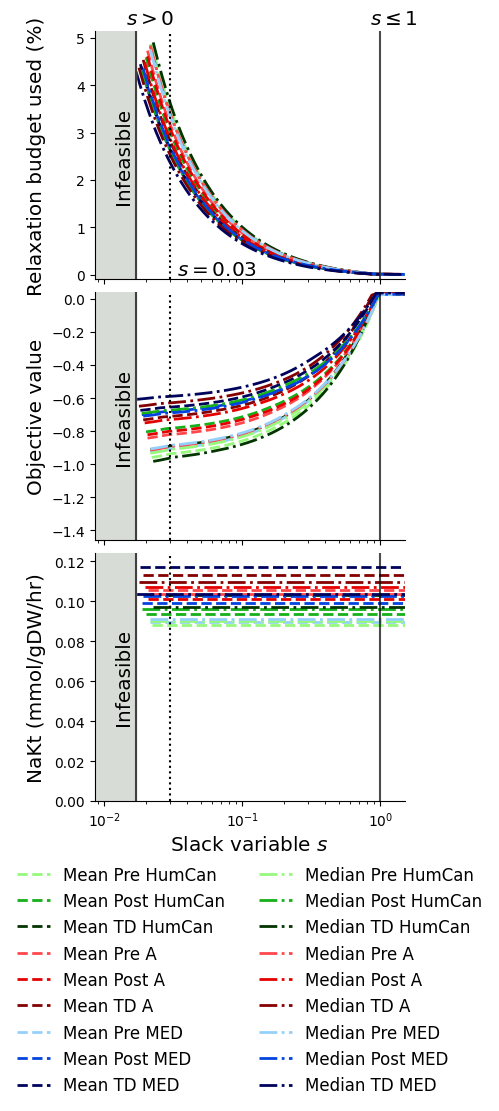

In [25]:
chosen_slack_var = 0.03
colors = {
    "Pre_HumCan": "xkcd:light green",
    "Pre_MED": "xkcd:light blue",
    "Pre_A": "xkcd:light red",
    "Post_HumCan": "xkcd:green",
    "Post_MED": "xkcd:blue",
    "Post_A": "xkcd:red",
    "TD_HumCan": "xkcd:dark green",
    "TD_MED": "xkcd:dark blue",
    "TD_A": "xkcd:dark red",
}
linestyles = {
    "Mean": "--",
    "Median": "-.",
}
use_percents = True

fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()

# ax3d = fig.add_subplot(2, 2, 4, projection="3d")
sns.despine(fig)
for pcmodel_sample in list(solutions):
    op, group = pcmodel_sample.replace(f"{pcmodel.id}_", "").split("_", maxsplit=1)
    color = colors.get(group, "xkcd:black")
    linestyle = linestyles.get(op, ":")
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_reactions)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample}: ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.2
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (
            -0.001 * (100 if use_percents else 1),
            max(r_values) * limit_pad_sclar,
        )
    elif i == 1:
        ymin, ymax = (
            min(0, min(o_values) * 2) * limit_pad_sclar,
            max(o_values) * limit_pad_sclar,
        )
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, 0),
            xycoords="data",
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
labels = [label.replace(f"{pcmodel.id}_", "").replace("_", " ") for label in labels]
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=2,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel(f"{'+'.join(objective_reactions)} (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

In [26]:
pd.DataFrame(
    [],
    index=[],
    columns=[],
)

""


In [27]:
for pcmodel_sample in list_of_pcmodels:
    update_slack_value(pcmodel_sample, chosen_slack_var, verbose)
    pcmodel_sample.objective = (
        sum(
            [
                r.flux_expression
                for r in pcmodel_sample.reactions.get_by_any(objective_reactions)
            ]
        )
    )
    upper_bounds = []
    objective_values = []
    

Relaxation budget updated for RBC_GEM_PC_Mean_Pre_HumCan, extra 29.2119 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_Post_HumCan, extra 29.2377 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_TD_HumCan, extra 29.2010 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_Pre_A, extra 29.2531 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_Post_A, extra 29.2233 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_TD_A, extra 29.2151 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_Pre_MED, extra 29.2240 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_Post_MED, extra 29.2691 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget updated for RBC_GEM_PC_Mean_TD_MED, extra 29.2825 mg/gDW (

In [28]:
# for pcmodel_sample in list_of_pcmodels:
#     update_slack_value(pcmodel_sample, chosen_slack_var, verbose)
#     pcmodel_sample.objective = (
#         sum(
#             [
#                 r.flux_expression
#                 for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
#             ]
#         )
#     )
#     upper_bounds = []
#     objective_values = []
#     with pcmodel_sample:
#         PBDL_relaxation_budget = pcmodel_sample.reactions.PBDL_relaxation_budget
    
#         for upper_bound in np.geomspace(PBDL_relaxation_budget.upper_bound, 1e-2, 501):
#             PBDL_relaxation_budget.upper_bound = upper_bound
#             upper_bounds.append(upper_bound)
#             objective_values.append(pcmodel_sample.slim_optimize())
#     ax.semilogx(upper_bounds, objective_values, label=pcmodel_sample.id.replace(f"{pcmodel.id}_", "").replace("_", " "))

In [29]:
# for pcmodel_sample in list_of_pcmodels:
#     update_slack_value(pcmodel_sample, chosen_slack_var, verbose)

### Formulate models from QP solutions

In [30]:
overwrite = False

# In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}
slack_value = chosen_slack_var  # Slack %
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, objective_value, r2_values) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [sample_pcmodels_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]) and not overwrite:
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Model already created for RBC_GEM_PC_A10_Post
Model already created for RBC_GEM_PC_A10_Pre
Model already created for RBC_GEM_PC_A10_TD
Model already created for RBC_GEM_PC_A11_Post
Model already created for RBC_GEM_PC_A11_Pre
Model already created for RBC_GEM_PC_A11_TD
Model already created for RBC_GEM_PC_A12_Post
Model already created for RBC_GEM_PC_A12_Pre
Model already created for RBC_GEM_PC_A12_TD
Model already created for RBC_GEM_PC_A1_Post
Model already created for RBC_GEM_PC_A1_Pre
Model already created for RBC_GEM_PC_A1_TD
Model already created for RBC_GEM_PC_A2_Post
Model already created for RBC_GEM_PC_A2_Pre
Model already created for RBC_GEM_PC_A2_TD
Model already created for RBC_GEM_PC_A3_Post
Model already created for RBC_GEM_PC_A3_Pre
Model already created for RBC_GEM_PC_A3_TD
Model already created for RBC_GEM_PC_A4_Post
Model already created for RBC_GEM_PC_A4_Pre
Model already created for RBC_GEM_PC_A4_TD
Model already created for RBC_GEM_PC_A5_Post
Model already created 